<a href="https://www.kaggle.com/code/dsashutosh/naive-bayes-with-pca-and-hyperparameter-tuning?scriptVersionId=125064821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #drawinggraphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split #train-test split 
from sklearn.preprocessing import StandardScaler, scale # scale and center the data
from sklearn.svm import SVC # SVM for classification
from sklearn.model_selection import GridSearchCV # this will do cross validation
from sklearn.metrics import confusion_matrix #this creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix #draws a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv


In [2]:
# Load the dataset

df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Content <a id='content'></a>
There are 25 variables:

* **ID**: ID of each client
* **LIMIT_BAL**: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* **SEX**: Gender (1=male, 2=female)
* **EDUCATION**: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* **MARRIAGE**: Marital status (1=married, 2=single, 3=others)
* **AGE**: Age in years
* **PAY_x**: Repayment status for last 6 months (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, … 8=payment delay for eight months, 9=payment delay for nine months and above)
* **BILL_AMTx**: Amount of bill statement for last 6 months (NT dollar)
* **PAY_AMTx**: Amount of previous payment for last 6 months (NT dollar)
* **default.payment.next.month**: Default payment (1=yes, 0=no)

In [3]:
#Rename Default column
#Drop ID column

df.rename({"default.payment.next.month":"DEFAULT"}, axis=1, inplace=True)
df.drop("ID", axis=1, inplace=True)
df.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1


# Missing Data

## 1. Identifying Missing Data

In [4]:
df.dtypes

LIMIT_BAL    float64
SEX            int64
EDUCATION      int64
MARRIAGE       int64
AGE            int64
PAY_0          int64
PAY_2          int64
PAY_3          int64
PAY_4          int64
PAY_5          int64
PAY_6          int64
BILL_AMT1    float64
BILL_AMT2    float64
BILL_AMT3    float64
BILL_AMT4    float64
BILL_AMT5    float64
BILL_AMT6    float64
PAY_AMT1     float64
PAY_AMT2     float64
PAY_AMT3     float64
PAY_AMT4     float64
PAY_AMT5     float64
PAY_AMT6     float64
DEFAULT        int64
dtype: object

Since every column is int64/float64, it's good, since none of them would have **NA** or other character based placeholder for missing values in dataframe **df**.

Lets make sure the column contains values which are acceptable and mentioned in the dataset description
[dataset description](#content)

In [5]:
#1. Let's make sure SEX has 2 values 1 & 2

df['SEX'].unique()

array([2, 1])

In [6]:
#2. Education should have 1-6 values, with 5,6 - unknown values
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0])

0 is not specified in the description, might be missing numbers<br>
5,6 are unknown values

In [7]:
#3. Marriage should have 1-3 values
df['MARRIAGE'].unique()

array([1, 2, 3, 0])

Like Education, Marriage also contains value 0, guess is that those are missing records

In [8]:
#4. AGE

df['AGE'].describe()

count    30000.000000
mean        35.485500
std          9.217904
min         21.000000
25%         28.000000
50%         34.000000
75%         41.000000
max         79.000000
Name: AGE, dtype: float64

In [9]:
#5. Default

df['DEFAULT'].unique()

array([1, 0])

## 2. Dealing with Missing Data

In [10]:
len(df.loc[(df['EDUCATION']==0) | (df['MARRIAGE']==0)])

68

So, only 68  rows have missing values. Now let's count the total number of rows in the dataset

In [11]:
100*len(df.loc[(df['EDUCATION']==0) | (df['MARRIAGE']==0)])/len(df)

0.22666666666666666

Less than 1% of data is missing, so we'll drop these records.

In [12]:
df_no_missing = df.loc[(df['EDUCATION']!=0) & (df['MARRIAGE']!=0)]
df_no_missing.shape

(29932, 24)

In [13]:
print('Education-',df_no_missing['EDUCATION'].unique(), 'Marriage-',df_no_missing['MARRIAGE'].unique())

Education- [2 1 3 5 4 6] Marriage- [1 2 3]


# Downsample the data

**Support Vector Machines** are great with small datasets, but not awesome with large ones, and this dataset, while not huge is big enough to take a long time to optimize with **Cross Validation**. So we'll downsample both categories, customers who did and did not default to 2000 each.

Let's check the customers in dataset

In [14]:
df_no_missing['DEFAULT'].value_counts()

0    23301
1     6631
Name: DEFAULT, dtype: int64

In [15]:
df_no_default =df_no_missing[df_no_missing['DEFAULT']==0]
df_default =df_no_missing[df_no_missing['DEFAULT']==1]

Now, downsample the dataset that did not default --

In [16]:
df_no_default_downsampled = resample(df_no_default, replace=False, n_samples=1000, random_state=42)
len(df_no_default_downsampled)

1000

Now, downsample the dataset that default --

In [17]:
df_default_downsampled = resample(df_default, replace=False, n_samples=1000, random_state=42)
len(df_default_downsampled)

1000

**Merge** these two downsampled dataframes into single dataframe--

In [18]:
df_downsample = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsample)

2000

# Format Data Part 1: Split the data into dependent & independent variables 

**Note:** We'll use `.copy()` method to create df X & y. Because by default pandas uses copy by reference. Using `copy()` ensures that the original data is not modified in case we make changes to X & y, so we won't have to reload the whole data and perform pre-processing steps again.

In [19]:
X = df_downsample.drop(['DEFAULT'], axis=1).copy()
y = df_downsample['DEFAULT'].copy()


In [20]:
X.head(2)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000.0,2,3,1,28,0,0,0,0,-2,...,50000.0,0.0,0.0,0.0,2500.0,1000.0,0.0,0.0,0.0,0.0
4678,170000.0,1,3,1,29,0,0,0,0,0,...,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,1200.0,1200.0,1500.0,1300.0


In [21]:
y.head(2)

641     0
4678    0
Name: DEFAULT, dtype: int64

# Format the Data Part2: One-Hot Encoding

SEX, EDUCATION, MARRIAGE & PAY_ are supposed to be categorical, so they'll be modified . This is because, while sklearn **Support Vector Machines** natively supports continuous data, like LIMIT_BAL, AGE, they do not natively support categorical data, like MARRIAGE which contains 3 different categories. Thus, we'll perform OHE on those columns.

In [22]:
X_encoded = pd.get_dummies(X, columns=['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000.0,28,100143.0,50456.0,50000.0,0.0,0.0,0.0,2500.0,1000.0,...,0,1,0,0,0,0,0,0,0,0
4678,170000.0,29,165027.0,168990.0,172307.0,35234.0,32869.0,33862.0,7200.0,7500.0,...,0,0,0,1,0,0,0,0,0,0
16004,180000.0,29,25781.0,26000.0,26310.0,26662.0,26166.0,26176.0,1800.0,1800.0,...,0,0,0,1,0,0,0,0,0,0
22974,210000.0,32,355.0,975.0,410.0,0.0,0.0,0.0,979.0,412.0,...,0,1,0,0,0,0,0,0,0,0
17535,190000.0,45,76433.0,78472.0,80548.0,81778.0,83082.0,84811.0,3300.0,3331.0,...,0,0,0,1,0,0,0,0,0,0


# Format the Data Part3: Centering and Scaling

The **Radial Basis Function (RBF)** that we are using with our **Support Vector Machine** assumes that the data are centered and scaled. In other words, each column should have a mean value=0 and a standard deviation of 1. So we neeed to do this to both the training and testing datasets.

***NOTE***: We split the data into training and testing datasets and then scale them separately to avoid the **Data Leakage**. <br>
**Data Leakage** occurs when information about the training dataset corrupts or influences the testing dataset.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Build a Preliminary Support Vector Machine

In [24]:
clf_svm = SVC(random_state=42)
clf_svm.fit(X_train_scaled,y_train)

SVC(random_state=42)

OK, so we've built a **SVM**  for classification. Let's check how it performs on the **Testing Dataset** and then draw a **Confusion Matrix**.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


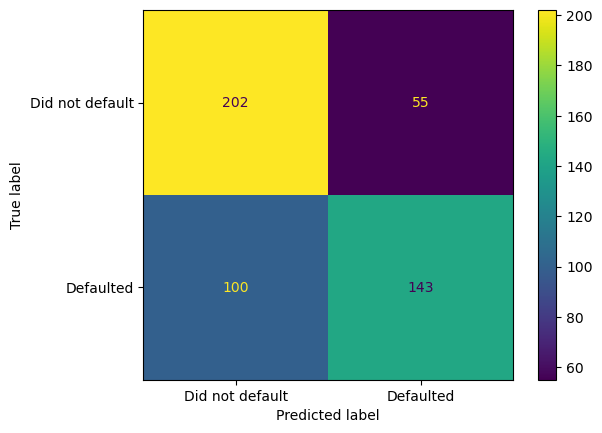

In [25]:
plot_confusion_matrix(clf_svm, 
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=["Did not default", "Defaulted"])

# Optimize Parameters with Cross Validation and GridSearchCV

Since we have two parameters to optimize, we will use `GridSearchCV`. We specify a bunch of potential values for **gamma** and **C**, and `GridSearchCV` will search all possible combinations of the parameters.

In [26]:
param_grid = [
    {
       'C':[0.5,1,10,100], # Values of C should be > 0 
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    },
]
## I have added C=1 & gamma='scale' as possible choices as well, since they are default values

optimal_params= GridSearchCV(
                            SVC(), param_grid, cv=5, scoring='accuracy', verbose=0
)
# Try changing scoring
## didn't changed the results much in my case

optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)


{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


And we can see that the ideal value for `C is 100` which means we'll use Regularization, and the ideal value for `gamma = 0.001`

# Buidling, Evaluating, Drawing and Interpreting the Final SVM

Now using the obtained values of C and gamma we'll build our final model

In [27]:
clf_svm = SVC(C=100, gamma=0.001, random_state=42)
clf_svm.fit(X_train_scaled, y_train)

SVC(C=100, gamma=0.001, random_state=42)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


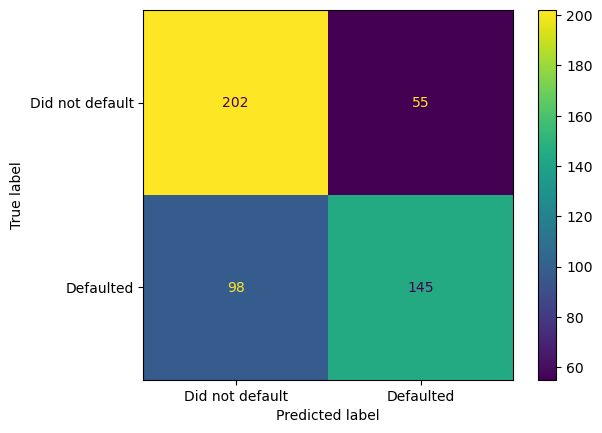

In [28]:
plot_confusion_matrix(clf_svm, X_test_scaled, y_test,
                     values_format='d', display_labels=['Did not default', 'Defaulted'])

And the results from the optimized **Support Vector Machine** are just a little bit better than before. **2** more people were correctly classified as not defaulting.

In other words, the **SVM** was pretty good straight out of the box without much optimization. This makes **SVMs** a great, quick and dirty method for relatively small datasets.

**NOTE:** Although classification with this dataset and an **SVM** is not awesome, it may be better than other methods. We'd have to compare to find out.<br><br>
The last thing we are going to do is draw a support vector machine decision boundary and discuss how to interpret it.<br><br>
The first we need to do is count the number of columns in **X**:

In [29]:
len(df_downsample.columns)

24

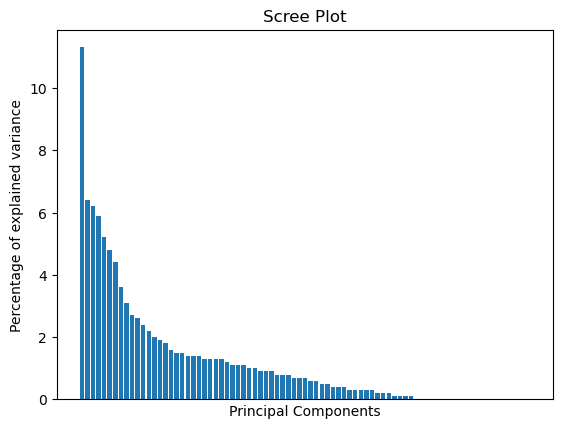

In [30]:
pca = PCA()# By default, PCA centers the data but does not scale it.
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x', #changes apply to the x-axis
    which='both', #both major and minor ticks are affected
    bottom=False, #ticks along the bottom edge are off
    top=False,    #ticks along the top edge are off
    labelbottom=False #labels along the bottom edge are off
)
plt.ylabel('Percentage of explained variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

The scree plot shows that the first principal component, PC1, accounts for a relatively large amount of variation in the raw data, and this means it will be a good candidate for the x-axis in the 2-D graph. However PC2 is not much different from PC3 or PC4, which doesn't bode well for dimension reduction.

Since we don't have a choice let's go with it. Graph will look funky though!!

Let's draw the PCA graph. First let's optimize an SVM fit to PC1 and PC2.

In [31]:
train_PC1_coords = X_train_pca[:,0]
train_PC2_coords = X_train_pca[:,1]

## NOTE:
## PC1 contains x-axis coordinates of the data after PCA
## PC2 contains y-axis coordinates of the data after PCA

## Now center and scale the PCs...
pca_train_scaled = scale(np.column_stack((train_PC1_coords,train_PC2_coords)))

## Now we optimize the SVM fit to the x-axis and y-axis coordinates
## of the data after PCA dimensionality reduction...

param_grid = [
    {
       'C':[1,10,100,1000], # Values of C should be > 0 
        'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
        'kernel': ['rbf']
    },
]

optimal_params = GridSearchCV(
    SVC(),  # use SVC() as the estimator to optimize
    param_grid,  # the grid of hyperparameters to search
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',  # optimize for accuracy
    verbose=0  # don't display progress messages
)

optimal_params.fit(pca_train_scaled, y_train)  # fit the optimal_params object to the data
print(optimal_params.best_params_)  # print the optimal hyperparameters found by GridSearchCV


{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}


Now that we have the optimal values for `C` and `gamma` let's draw the graph

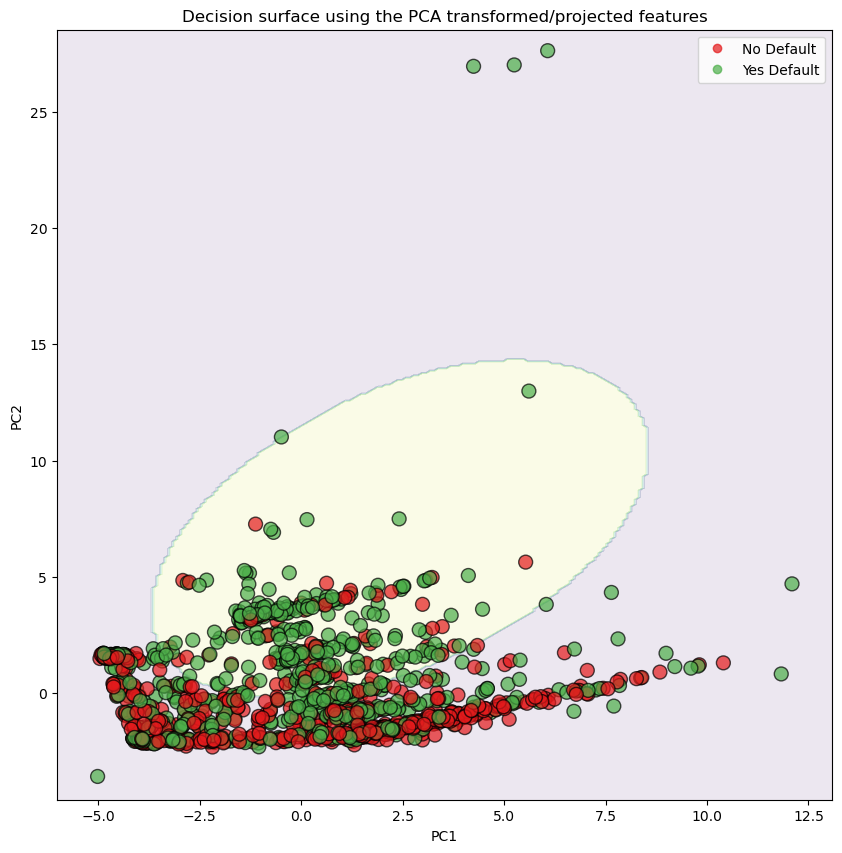

In [32]:
clf_svm = SVC(C=1000, gamma=0.001, random_state=42)
clf_svm.fit(pca_train_scaled, y_train)

## Transform the test dataset with the PCA...
X_test_pca = pca.transform(X_train_scaled)
#X_test_pca = pca.transform(X_test_scaled)
test_pc1_coords = X_test_pca[:,0]
test_pc2_coords = X_test_pca[:,1]

## Now create a matric of points that we can use to show the decision regions/
## The matrix will be a little bit larger than the transformed
## PCA points so that we can plot all of the PCA points on it without them being on the edge
x_min = test_pc1_coords.min() - 1
x_max = test_pc1_coords.max() + 1

y_min = test_pc2_coords.min() - 1
y_max = test_pc2_coords.max() + 1

xx, yy = np.meshgrid(np.arange(start=x_min, stop=x_max, step=0.1),
                     np.arange(start=y_min, stop=y_max, step=0.1))

## Now we'll classify every point in that
## matrix with the SVM. Points on one side of the
## Classification boundary will get 0, and points on the other
## side will get 1.
Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)

## Plot the decision boundary and the scatter plot of the PCA-transformed test data
fig, ax = plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, Z, alpha =0.1)
cmap = colors.ListedColormap(['#e41a1c', '#4daf4a'])

scatter = ax.scatter(test_pc1_coords, test_pc2_coords, c=y_train, cmap=cmap, s=100, edgecolors='k',alpha=0.7)
legend = ax.legend(scatter.legend_elements()[0],
                  scatter.legend_elements()[1],
                   loc="upper right")
legend.get_texts()[0].set_text("No Default")
legend.get_texts()[1].set_text("Yes Default")

## now add axis labels and titles
ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
ax.set_title('Decision surface using the PCA transformed/projected features')
plt.show()


The pink part of the graph is the area where all the datapoints to have not *not defaulted*. The yellow part of the graph is the area where all the datapoints will be predicted to have *defaulted*. The dots are datapoints in the training dataset and are color coded by their known classifications: red is for those that did *not default* and green is for those that *defaulted*.

**NOTE**: The results are show the training data, not the testing data and thus, do not match the confusion matrics that we generated. Also, remember that for this picture, we only fit the SVM to the first Principal Components instead of all the data, and thus, this is only an approximation of the true classifier. Lastly, because the skree plot showed that PC2 was not very different from PC3 or PC4, this is not a very good approximation.